In [259]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [260]:
bag = rosbag.Bag('/home/uware/rosbags/static/rotation/16h5/s_yaw_16h5_2m_1080_20.bag')

# create variables
target = 'yaw'
true_value = 'true_yaw'

# input values in degrees. the order matters, it will be used for binning 
input_vals = [0,15,30,45,60,75]

In [261]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t

    # conversion to euler
    rotation_quat = msg.transforms[0].transform.rotation
    pitch, yaw, roll = tf.transformations.euler_from_quaternion([rotation_quat.x,rotation_quat.y,rotation_quat.z,rotation_quat.w], axes='rxyz')

    # all rotations
    # rotation_euler = (np.degrees(pitch), np.degrees(yaw), np.degrees(roll))

    # create row
    row={'time': time.to_sec(), target: np.degrees(yaw)}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [262]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,yaw
0,0.000000,25.541046
1,0.987709,34.322809
2,0.987742,14.342188
3,1.771374,31.282950
4,2.623864,14.364782
...,...,...
330,112.167772,74.517263
331,112.464301,74.455190
332,112.895325,74.755862
333,113.256053,71.017223


<AxesSubplot:xlabel='relative_time'>

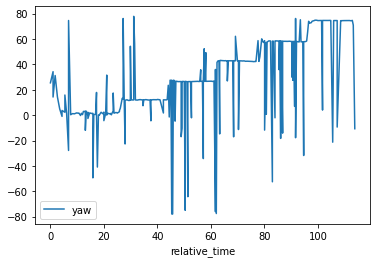

In [263]:
# initial graph
df.plot(x='relative_time', y=target)

In [264]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, 10)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [265]:
# the amount of data points we are left with
len(x[peaks])

48

In [266]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='yaw'>

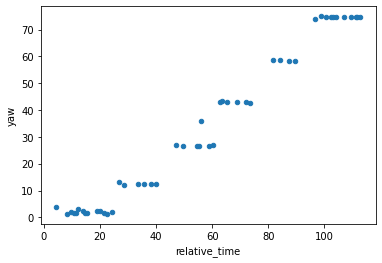

In [267]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [268]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.qcut(df_filtered_by_targets[target], len(input_vals), labels=input_vals, duplicates='drop')

In [269]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df_filtered_by_targets)

,relative_time,yaw,true_yaw
7,4.339466,3.763341,15
15,8.227692,1.248493,0
17,9.811062,1.814782,0
19,10.662312,1.675628,0
21,11.598482,1.540559,0
23,12.335932,2.994214,15
30,14.023890,2.304319,15
32,14.650257,1.750822,0
35,15.551916,1.466215,0
47,18.960724,2.320185,15


In [270]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [271]:
# remove huge errors because theyre actually wrongly binned
df_filtered_by_targets = df_filtered_by_targets.drop(df_filtered_by_targets[df_filtered_by_targets['error'].abs()>10].index)

In [272]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [273]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.head(2)

,relative_time,yaw,true_yaw,error
15,8.227692,1.248493,0,-1.248493
17,9.811062,1.814782,0,-1.814782
76,28.641359,12.169825,15,2.830175
107,38.349584,12.249572,15,2.750428
139,49.597683,26.656382,30,3.343618
154,54.481879,26.670289,30,3.329711
159,56.206071,35.811331,45,9.188669
183,62.717164,42.908334,45,2.091666
239,81.666340,58.597664,60,1.402336
247,84.307770,58.602944,60,1.397056


In [274]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_yaw,,,,,,,,
0,8.0,-1.549331,0.193716,-1.814782,-1.694427,-1.542350,-1.438163,-1.248493
15,2.0,2.790302,0.056390,2.750428,2.770365,2.790302,2.810238,2.830175
30,4.0,3.306500,0.035773,3.269167,3.279920,3.306608,3.333188,3.343618
45,6.0,3.305982,2.886340,1.973490,2.016761,2.134244,2.354295,9.188669
60,4.0,1.542684,0.165160,1.397056,1.401016,1.541860,1.683529,1.689961
75,8.0,0.263972,0.091020,0.070507,0.241349,0.273573,0.324357,0.358930


In [275]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

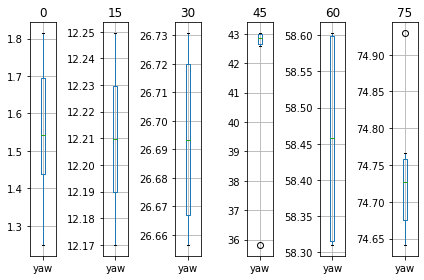

In [276]:
box_plotter(target)

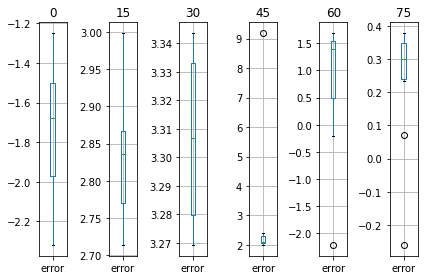

In [258]:
box_plotter('error')